In [8]:
%load_ext autoreload
%autoreload 2

import json
import os.path as osp
import os,sys
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_undirected
from torch_cluster import radius_graph, knn_graph
from torch_geometric.datasets import MNISTSuperpixels
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from tqdm import tqdm
import argparse
import warnings
warnings.simplefilter('ignore')
from time import strftime, gmtime
import matplotlib.pyplot as plt

sys.path.append('../')
import utils
import model.net as net
import model.data_loader as data_loader
from evaluate import evaluate
from train import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
pre_fix = '/export/home/phys/kyungmip/L1DeepMETv2_workspace/'

data_dir = pre_fix + 'data_ttbar/'        # name of the data folder
ckpts = pre_fix + 'ckpts_Feb13/'       # name of the ckpts folder

In [5]:
epochs = 20
batch_size = 1
lr = 1e-4
weight_decay = 0.001

In [6]:
n_features_cont = 6
n_features_cat = 2

In [20]:
def plot_particles(etaphi, edge_index, x_cat, x_cont):
    
    plt.figure(figsize=(8, 8))
    
    plt.xlabel('eta')
    plt.ylabel('phi')
    
    # puppi weight
    x_cont = x_cont.cpu()
    w_puppi = x_cont[:,-1]
    #print(w_puppi)
    
    # pdg Id
    pdg_map = [1, 2, 11, 13, 22, 130, 211]
    
    x_cat = x_cat.cpu()
    abs_pdg = torch.abs(x_cat[:,0]).numpy()
    #print(abs_pdg)
    
    # eta phi
    etaphi = etaphi.cpu()
            
    print(f'Number of particles (nodes): {len(etaphi)}')
    
    eta = etaphi[:,0].tolist()
    phi = etaphi[:,1].tolist()
    
    # plt.scatter(eta, phi)

    # plot edges
    edge_index = edge_index.cpu()
    
    nEdges = edge_index.size()[1]
    print(f'Number of edges: {nEdges}')
    
    for idx in range(nEdges):
        src = edge_index[0][idx]
        dest = edge_index[1][idx]
        #print(f'Edge {idx}: connect the node {src} at ({eta[src]:.2f},{phi[src]:.2f}) to the node {dest} at ({eta[dest]:.2f},{phi[dest]:.2f})')
    
        plt.plot([eta[src], eta[dest]], [phi[src], phi[dest]], 'r-', linestyle='dotted')
    
    # plot particles    
    for i in range(len(pdg_map)):
        idx_part = (abs_pdg == pdg_map[i])
        #print(f'pdg = {pdg_map[i]}: {np.count_nonzero(idx_part)}')
        
        eta_part = etaphi[:,0].numpy()[idx_part]
        phi_part = etaphi[:,1].numpy()[idx_part]
        
        plt.scatter(eta_part, phi_part, label=f'abs(pdg) = {pdg_map[i]}')

    
    #plt.legend()
    plt.show()

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
dataloaders = data_loader.fetch_dataloader(data_dir = data_dir, batch_size=int(batch_size), validation_split=.2)

train_dl = dataloaders['train']
test_dl = dataloaders['test']

print('Training dataloader: {}, Test dataloader: {}'.format(len(train_dl), len(test_dl)))

Split: 167410
length of train/val data:  669644 167410
Training dataloader: 669644, Test dataloader: 167410


  0%|          | 0/669644 [00:00<?, ?it/s]

Number of particles (nodes): 19
Number of edges: 16


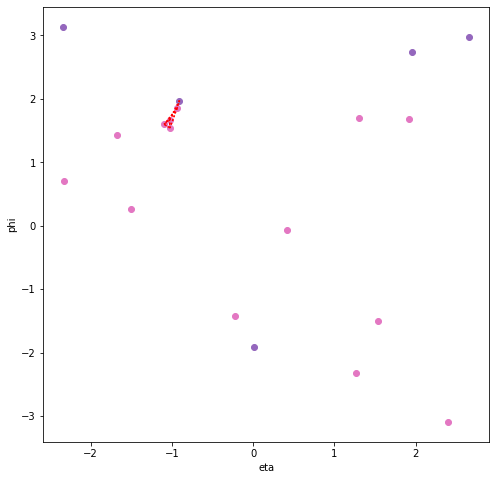

Number of particles (nodes): 60
Number of edges: 284


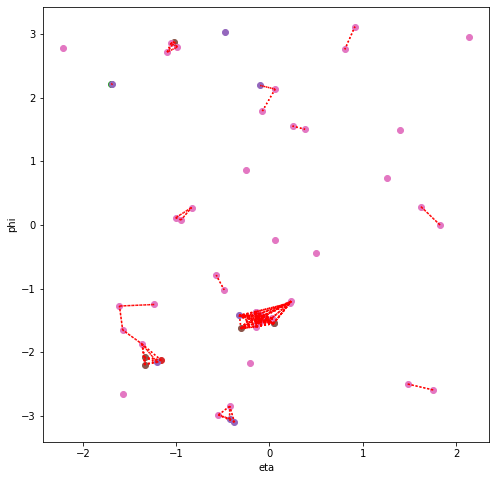

Number of particles (nodes): 32
Number of edges: 52


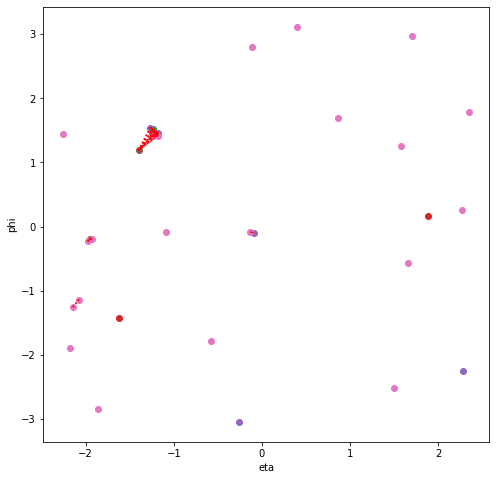

Number of particles (nodes): 47
Number of edges: 114


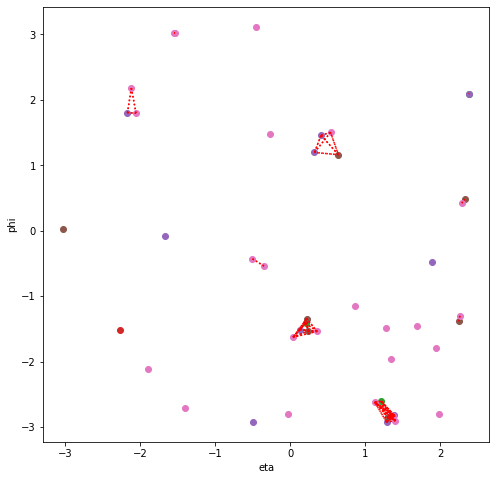

Number of particles (nodes): 75
Number of edges: 120


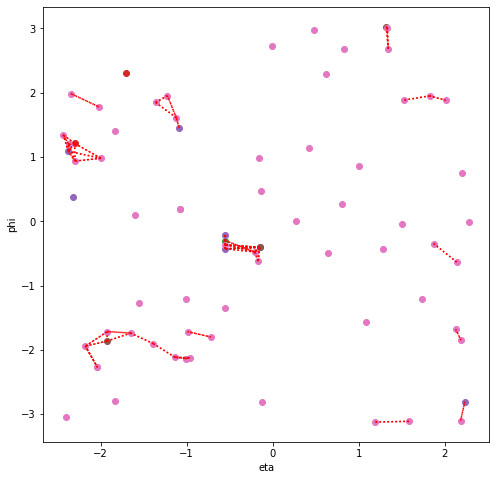

Number of particles (nodes): 34
Number of edges: 110


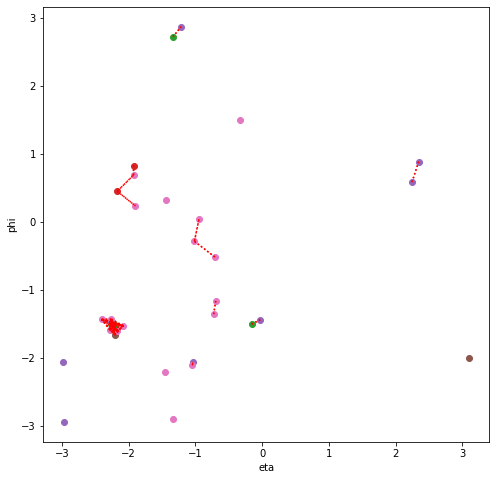

Number of particles (nodes): 45
Number of edges: 146


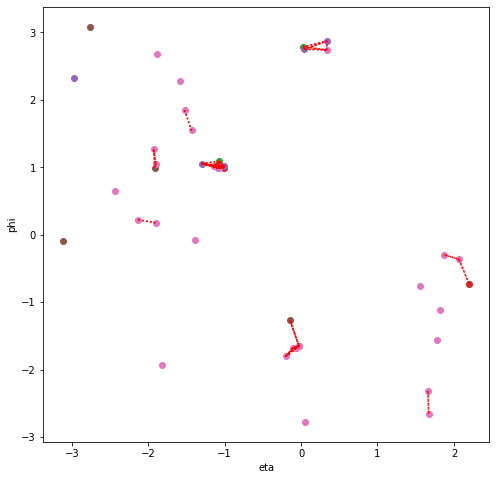

Number of particles (nodes): 55
Number of edges: 172


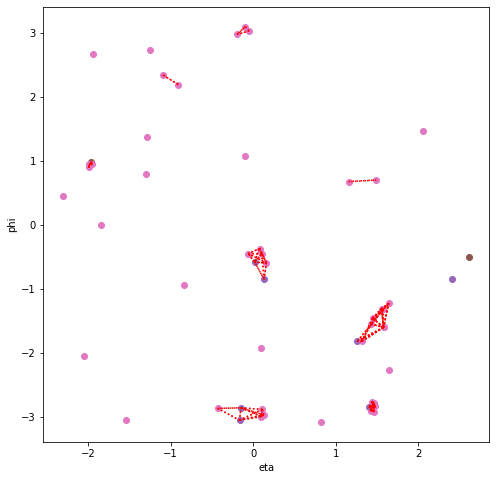

Number of particles (nodes): 60
Number of edges: 122


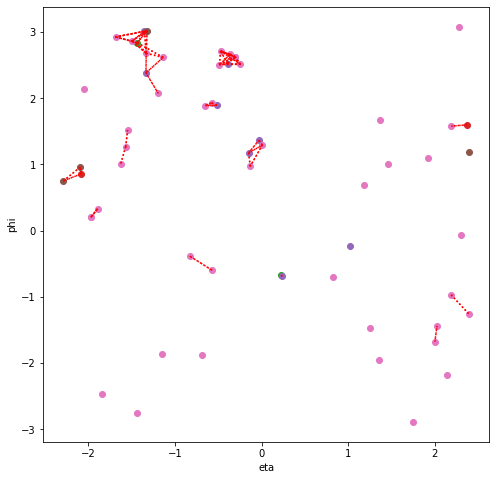

Number of particles (nodes): 81
Number of edges: 248


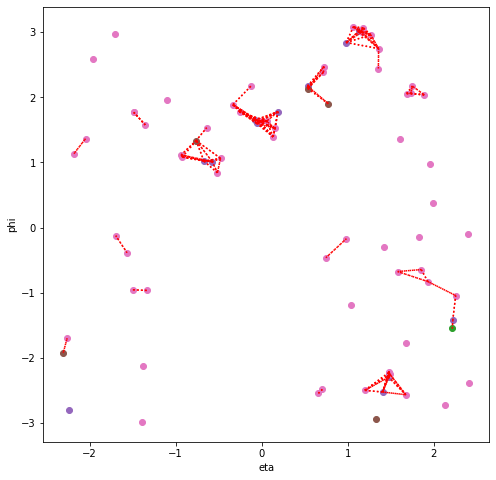

Number of particles (nodes): 41
Number of edges: 170


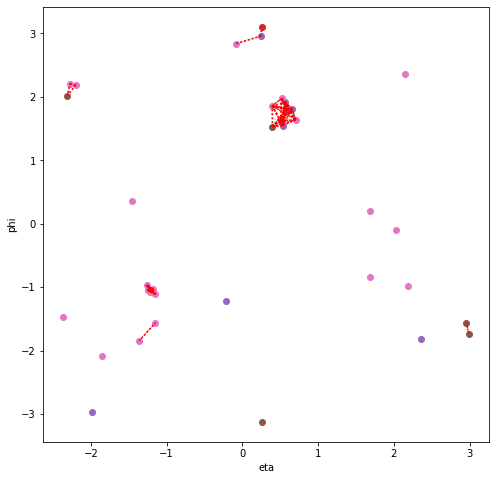

  0%|          | 0/669644 [00:06<?, ?it/s]


In [22]:
dataloader = train_dl
    
with tqdm(total=len(dataloader)) as t:
    for idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        data = data.to(device)

        x_cont = data.x[:,:n_features_cont]       # include puppi
        #x_cont = data.x[:,:(n_features_cont-1)]  # remove puppi
        x_cat = data.x[:,n_features_cont:].long()

        #phi = torch.atan2(data.x[:,2], data.x[:,1])   # atan2(py, px)
        etaphi = torch.cat([data.x[:,3][:,None], data.x[:,4][:,None]], dim=1)

        # NB: there is a problem right now for comparing hits at the +/- pi boundary
        edge_index = radius_graph(etaphi, r=deltaR, batch=data.batch, loop=False, max_num_neighbors=255)  # turn off self-loop

        plot_particles(etaphi, edge_index, x_cat, x_cont)
        
        if idx >= 10:
            break